# Back propagation vs Numerical Differentiation

**What if we replace backpropagation with numerical differentiation to compute the loss gradient?**

In [10]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## Load and preprocess the MNIST dataset

Path to dataset files: C:\Users\Beom\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1


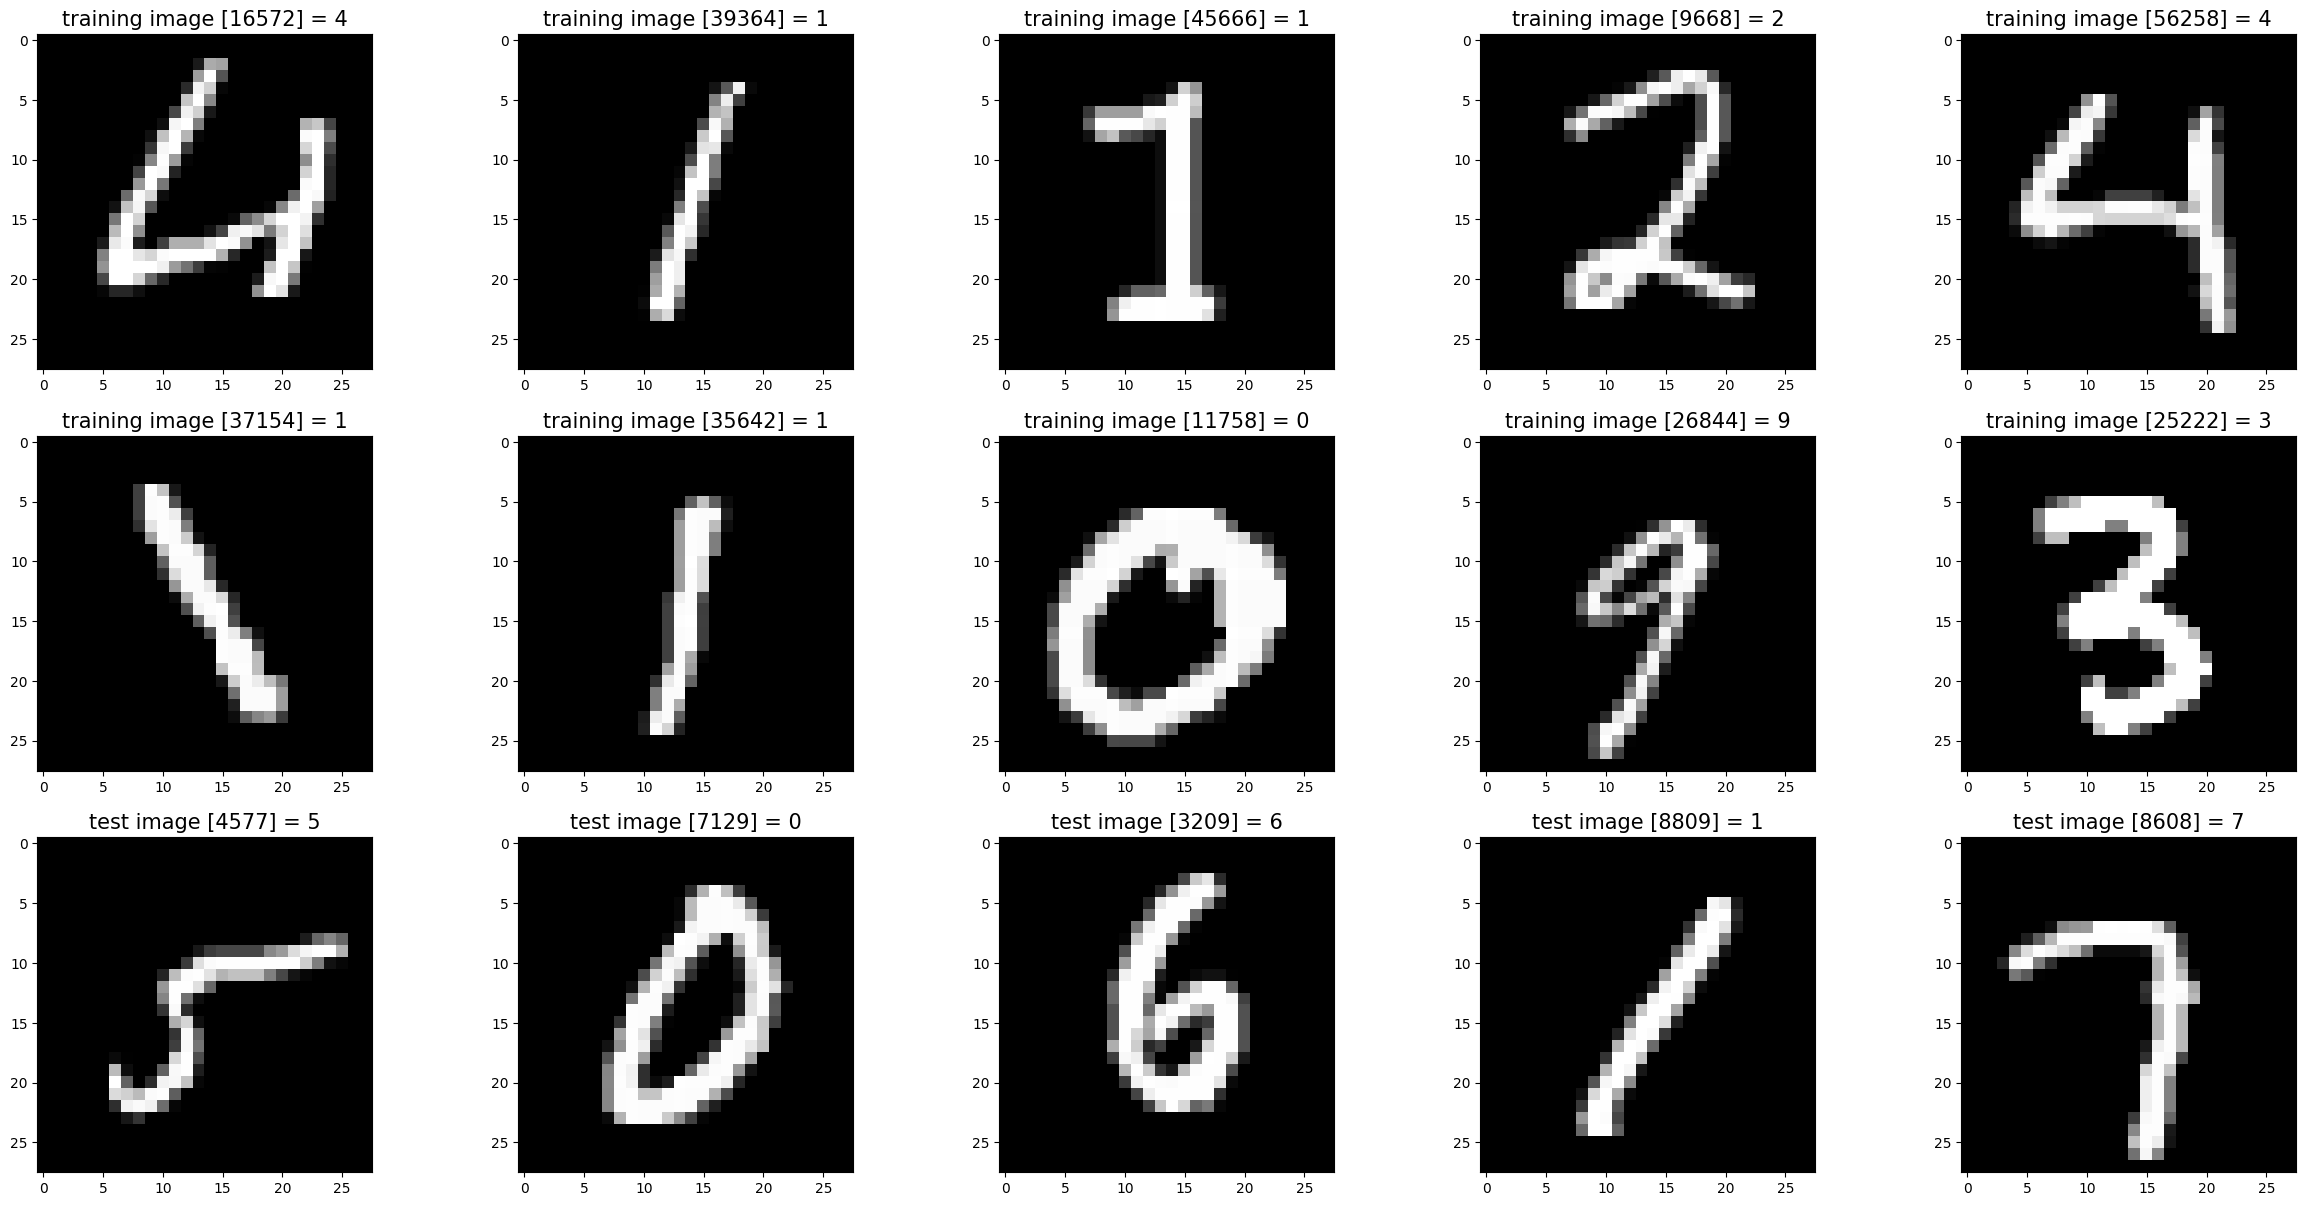

In [11]:
import kagglehub
import sys
sys.path.append('..')
from os.path import join
from dataset.mnist import MnistDataloader
import numpy as np

%matplotlib inline

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")
print("Path to dataset files:", path)

training_images_filepath = join(path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


mnist_dataloader.show_random_data(x_train, x_test, y_train, y_test)



x_train = np.array(x_train).reshape(-1,784)
y_train = np.array(y_train)
x_test = np.array(x_test).reshape(-1,784)
y_test = np.array(y_test)

## Mnist classification with Multilayer Perceptron (Ogrigin)
### Train start with Back propagation

In [18]:
import numpy as np
from models.multilayer_perceptron import Two_Layer_MLP
from utils.metric import accuracy
from utils.normalization import min_max_scale


batch_size = 100
model = Two_Layer_MLP(input_size=784, hidden_size=50, output_size=10)
learning_rate = 0.1
epoch = 100

scaled_x_train = min_max_scale(x_train)
scaled_x_test = min_max_scale(x_test)

origin_accuracies = []
origin_losses = []

for i in range(epoch):
    print(f"epoch: {i}")
    indices = np.random.choice(scaled_x_train.shape[0], batch_size, replace=False)
    x_batch = scaled_x_train[indices]
    y_batch = y_train[indices]
    model.x_train = x_batch
    model.y_train = y_batch

    # forward
    predict = model.forward()

    # backward
    model.backward()
    for key in model.grads:  # Iterate over each of W1, W2, b1, and b2
        model.params[key] -= learning_rate * model.grads[key]

    # loss
    loss = model.loss_func()
    origin_losses.append(loss)
    print("loss: ", loss)

    # test accuray
    y_infer = model.inference(scaled_x_test)
    acc = accuracy(y_test, y_infer)
    print(f"accuracy: ", acc)
    origin_accuracies.append(acc)

epoch: 0
loss:  2.3830179074036817
accuracy:  0.0959
epoch: 1
loss:  2.348391207636587
accuracy:  0.0981
epoch: 2
loss:  2.3181778954431715
accuracy:  0.0986
epoch: 3
loss:  2.326060051736891
accuracy:  0.096
epoch: 4
loss:  2.272823532040528
accuracy:  0.0961
epoch: 5
loss:  2.2723245041972264
accuracy:  0.0959
epoch: 6
loss:  2.2680303571970852
accuracy:  0.1097
epoch: 7
loss:  2.2892342198242104
accuracy:  0.1742
epoch: 8
loss:  2.2865861235262708
accuracy:  0.1311
epoch: 9
loss:  2.2956471202283186
accuracy:  0.2171
epoch: 10
loss:  2.251926497203754
accuracy:  0.2192
epoch: 11
loss:  2.246306903137919
accuracy:  0.2392
epoch: 12
loss:  2.263328755302121
accuracy:  0.3099
epoch: 13
loss:  2.2380625813904866
accuracy:  0.3593
epoch: 14
loss:  2.205218841188882
accuracy:  0.304
epoch: 15
loss:  2.2113820034245966
accuracy:  0.3363
epoch: 16
loss:  2.207133164837859
accuracy:  0.3432
epoch: 17
loss:  2.2038371162194874
accuracy:  0.2933
epoch: 18
loss:  2.2112716093982887
accuracy:  0

## Mnist classification with Multilayer Perceptron (Experimental)
### numerical differentiation

In [13]:
def numerical_gradient(f, y_true, x_data, params, h=1e-4):
    gradients = {}  # Dictionary to store the gradient of each parameter (W, b)

    for key in params:  # Iterate over each parameter: W1, W2, b1, b2
        param = params[key]  # Select the current parameter
        grad = np.zeros_like(param)  # Create a gradient array of the same shape

        if param.ndim == 1:  # If the parameter is a bias (vector)
            for i in range(param.shape[0]):  # Iterate over each element
                temp_params = params.copy()
                param_plus = param.copy()
                param_minus = param.copy()

                param_plus[i] += h  # Add h to b_i
                param_minus[i] -= h  # Subtract h from b_i

                # Compute the loss values for the bias
                temp_params[key] = param_plus
                loss_plus = f(y_true, x_data, temp_params)
                temp_params[key] = param_minus
                loss_minus = f(y_true, x_data, temp_params)

                grad[i] = (loss_plus - loss_minus) / (
                    2 * h
                )  # Compute central difference

        else:  # If the parameter is a weight (matrix)
            for i in range(param.shape[0]):  # Iterate over rows
                for j in range(param.shape[1]):  # Iterate over columns
                    temp_params = params.copy()
                    param_plus = param.copy()
                    param_minus = param.copy()

                    param_plus[i, j] += h  # Add h to w_ij
                    param_minus[i, j] -= h  # Subtract h from w_ij

                    # Compute the loss values for the weight
                    temp_params[key] = param_plus
                    loss_plus = f(y_true, x_data, temp_params)
                    temp_params[key] = param_minus
                    loss_minus = f(y_true, x_data, temp_params)

                    grad[i, j] = (loss_plus - loss_minus) / (
                        2 * h
                    )  # Compute central difference

        gradients[key] = grad  # Store the computed gradient

    return gradients  # Return all gradients





### Modified class : Numerical Gradient Based MLP 

In [14]:
from utils.metric import accuracy
from utils.normalization import min_max_scale

from utils.loss_functions import SoftMaxWithCEE
from utils.activation_functions import Sigmoid
from models.multilayer_perceptron import Two_Layer_MLP

class Numerical_Gradient_Based_MLP(Two_Layer_MLP):
    def forward(self, x_data, params):
        input_layer = (
            np.dot(x_data, params["w1"]) + params["b1"]
        )  # The bias is broadcasted and added across the batch size.
        input_layer = Sigmoid().forward(input_layer)

        output_layer = np.dot(input_layer, params["w2"]) + params["b2"]
        predict = SoftMaxWithCEE().softmax(output_layer)
        return predict

    def loss_func(self, y_true, x_data, params):

        y_pred = self.forward(x_data, params)
        loss = SoftMaxWithCEE().CEE(y_true, y_pred)
        return loss

    def backward(self, y_true, x_data):
        f = self.loss_func
        grads = numerical_gradient(f, y_true, x_data, self.params)
        return grads

## Train start with numerical differentiation

In [15]:
new_accuracies = []
new_losses = []

batch_size = 100
model = Numerical_Gradient_Based_MLP(input_size=784, hidden_size=50, output_size=10)
learning_rate = 0.1
epoch = 100

scaled_x_train = min_max_scale(x_train)
scaled_x_test = min_max_scale(x_test)

for i in range(epoch):
    print(f"epoch: {i}")
    indices = np.random.choice(scaled_x_train.shape[0], batch_size, replace=False)
    x_data = scaled_x_train[indices]
    y_data = y_train[indices]

    # Gradient descent
    grads = model.backward(y_data, x_data)
    for key in grads:  # Iterate over each parameter: W1, W2, b1, b2
        model.params[key] -= learning_rate * grads[key]

    # loss
    loss = model.loss_func(y_data, x_data, model.params)
    new_losses.append(loss)
    print("loss: ", loss)

    # test accuray
    y_infer = model.inference(scaled_x_test)
    acc = accuracy(y_test, y_infer)
    print(f"accuracy: ", acc)
    new_accuracies.append(acc)

epoch: 0
loss:  2.46478355391495
accuracy:  0.0889
epoch: 1
loss:  2.360328417113461
accuracy:  0.0878
epoch: 2
loss:  2.3570782779819925
accuracy:  0.1341
epoch: 3
loss:  2.3287686976304256
accuracy:  0.1423
epoch: 4
loss:  2.337807278224817
accuracy:  0.1312
epoch: 5
loss:  2.289288831675875
accuracy:  0.1829
epoch: 6
loss:  2.3001406549627155
accuracy:  0.222
epoch: 7
loss:  2.241988664533823
accuracy:  0.2246
epoch: 8
loss:  2.2860713895525464
accuracy:  0.2476
epoch: 9
loss:  2.2695711956486813
accuracy:  0.2513
epoch: 10
loss:  2.2221264995261447
accuracy:  0.2095
epoch: 11
loss:  2.2386920543466133
accuracy:  0.2392
epoch: 12
loss:  2.2307785428824634
accuracy:  0.2386
epoch: 13
loss:  2.218140972874403
accuracy:  0.1886
epoch: 14
loss:  2.198898493203551
accuracy:  0.1878
epoch: 15
loss:  2.2176416741470857
accuracy:  0.1842
epoch: 16
loss:  2.1855890437290695
accuracy:  0.3238
epoch: 17
loss:  2.2044917586996777
accuracy:  0.3705
epoch: 18
loss:  2.190469441436778
accuracy:  0

## Backpropagation vs Numerical differentiation

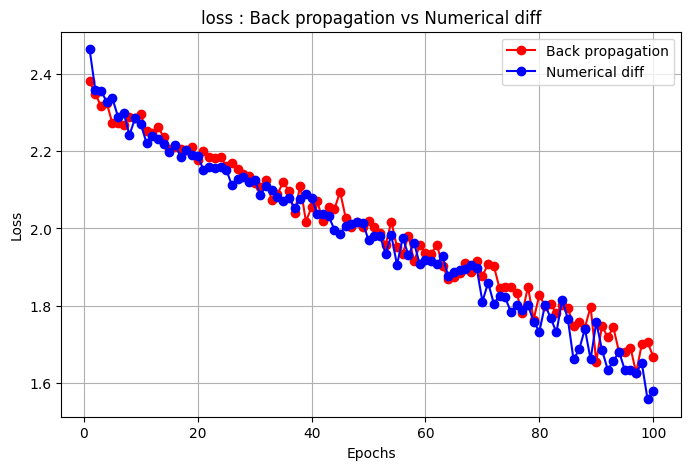

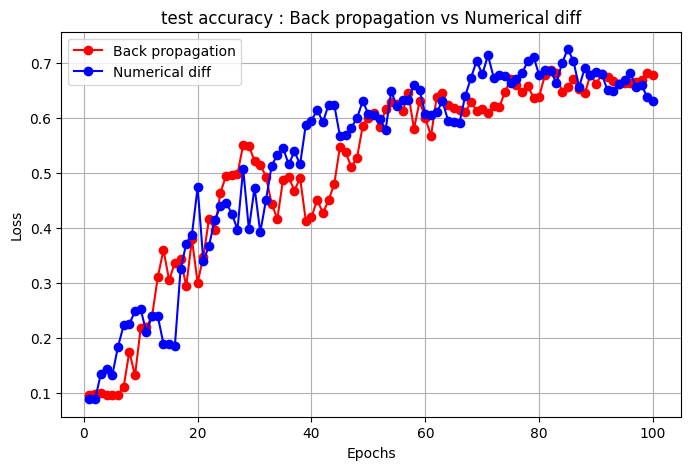

In [21]:
import matplotlib.pyplot as plt


def graph(g1: list, g2: list, g1_name: str, g2_name: str, topic:str):

    epochs = range(1, len(g1) + 1)  # Set the number of epochs

    plt.figure(figsize=(8, 5))

    # Graph 1
    plt.plot(epochs, g1, "ro-", label=g1_name)  # Red marker with a line

    # Graph 2
    plt.plot(epochs, g2, "bo-", label=g2_name)  # Blue circle marker with a line

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{topic} : {g1_name} vs {g2_name}")
    plt.legend()  # Add legend
    plt.grid(True)  # Add grid

    plt.show()

graph(origin_losses, new_losses, "Back propagation", "Numerical diff", topic="loss")
graph(
    origin_accuracies,
    new_accuracies,
    "Back propagation",
    "Numerical diff",
    topic="test accuracy",
)

### 📊 Performance Review   

| Method                     | Epochs ⏳ | Elapsed Time ⏱️  | Loss 📉       | Test Accuracy 🎯 |
|----------------------------|---------|----------------|--------------|----------------|
| **Backpropagation**       | 100     | 3.1s          | 1.6676       | 0.6783         |
| **Numerical Differentiation**  | 100     | 141m 55.3s    | 1.5788       | 0.6309         |
